# Dataset Generation


In [ ]:
import random
import numpy as np
import json

DATASET_SIZE = 1
OUTPUT_FILE = "demonstrations_pddl_style.txt"

# Item categories
CONTAINERS = ["pot", "pan", "plate", "bowl"]
INGREDIENTS = ["tomato", "meat", "onion", "mushroom", "lettuce", "egg", "rice", "mixture"]
ITEMS = CONTAINERS + INGREDIENTS
CUTTABLES = ["tomato", "onion", "mushroom", "lettuce"]
COOKABLES = ["meat", "egg", "rice", "tomato", "onion", "mushroom", "mixture"]

# Locations (places, not tools)
LOCATIONS = ["storage", "prep_station", "cooking_station", "plating_station", "serving_station", "washing_station"]
# LOC_MAP = {"A": "storage", "B": "prep_station", "C": "cooking_station", "D": "plating_station", "E": "serving_station", "F": "washing_station"}

# Tools at locations
TOOLS = {"prep_station": ["cutting_board"],     "cooking_station": ["stove"],       "washing_station": ["sink"]}


class StateTracker:
    """
    Enhanced state tracker with explicit containment and cooking status.
    
    State representation:
    - Item locations (11 items × 6 locations = 66 features)
    - Containment matrix (4 containers × 8 ingredients = 32 features, incl. mixture)
    - Cut status (4 cuttables = 4 features)
    - Cooked status (6 cookables = 6 features)
    - Washed status (11 items = 11 features)
    - Tool states (stove_on, sink_on = 2 features)
    - Plate served (1 feature)
    Total: ~118 features
    """
    def __init__(self):
        self.feature_map = {}
        idx = 0
        
        # 1. Item locations (11 items × 6 locations = 60)
        for item in ITEMS:
            for loc in LOCATIONS:
                self.feature_map[f"{item}_at_{loc}"] = idx
                idx += 1
        # 2. Containment (container_contains_item: 4 containers × 7 ingredients = 21)
        for container in CONTAINERS:
            for ingredient in INGREDIENTS:
                self.feature_map[f"{container}_contains_{ingredient}"] = idx
                idx += 1
        # 3. Cut status (4 cuttables)
        for item in CUTTABLES:
            self.feature_map[f"{item}_cut"] = idx
            idx += 1
        # 4. Cooked status (6 cookables)
        for item in COOKABLES:
            self.feature_map[f"{item}_cooked"] = idx
            idx += 1
        # 5. Washed status (11 items)
        for item in ITEMS:
            self.feature_map[f"{item}_washed"] = idx
            idx += 1
        # 6. Tool states
        self.feature_map["stove_on"] = idx
        idx += 1
        self.feature_map["sink_on"] = idx
        idx += 1
        # 7. Task completion
        self.feature_map["plate_served"] = idx
        idx += 1
        
        self.n_features = idx
        self.reset()
        print(f"Total state features: {self.n_features}")
        print(f"Feature dimensions: Locations={len(ITEMS)*len(LOCATIONS)}, "
              f"Containment={len(CONTAINERS)*len(INGREDIENTS)}, "
              f"Cut={len(CUTTABLES)}, Cooked={len(COOKABLES)}, "
              f"Washed={len(ITEMS)}, Tools=2, Served=1")
    
    def reset(self):
        """Reset to initial state: all items at storage, nothing contained/cut/cooked/washed"""
        self.current_state = np.zeros(self.n_features, dtype=int)
        # All items start at storage
        for item in ITEMS: self.set_feature(f"{item}_at_storage", 1)
    
    def set_feature(self, key, value):
        if key in self.feature_map: self.current_state[self.feature_map[key]] = value
    
    def get_feature(self, key):
        return self.current_state[self.feature_map.get(key, -1)] if key in self.feature_map else 0
    
    def get_state_vector(self):
        return self.current_state.copy()
    
    def get_item_location(self, item):
        """Get current location of an item"""
        for loc in LOCATIONS:
            if self.get_feature(f"{item}_at_{loc}") == 1: return loc
        return None
    
    def is_contained(self, item):
        """Check if item is inside any container"""
        for container in CONTAINERS:
            if self.get_feature(f"{container}_contains_{item}") == 1:
                return container
        return None
    
    def apply_action(self, action_str):
        """
        Parse and apply PDDL-style actions with precondition checking.
        
        Actions:
        - transfer (item, from_loc, to_loc): Move item between locations (not in container)
        - load (item, container, location): Put item into container
        - unload (item, container, location): Remove item from container
        - move_container (container, from_loc, to_loc): Move container with contents
        - cut (item, location): Cut item at location
        - cook (item, container, location): Cook item in container
        - turn_on/turn_off (tool, location): Control tools
        - serve (plate, location): Mark plate as served
        - wash (item, location): Wash item
        """
        action_str = action_str.strip()
        
        if action_str.startswith("transfer"):
            # transfer (item, from=loc1, to=loc2)
            content = action_str[action_str.find("(")+1:action_str.find(")")]
            parts = [p.strip() for p in content.split(",")]
            item = parts[0]
            from_loc = parts[1].split("=")[1] if "=" in parts[1] else parts[1]
            to_loc = parts[2].split("=")[1] if "=" in parts[2] else parts[2]
            
            # Precondition: item at from_loc, not contained
            if self.get_feature(f"{item}_at_{from_loc}") != 1:                          raise ValueError(f"Precondition failed: {item} not at {from_loc}")
            if self.is_contained(item):                                                 raise ValueError(f"Precondition failed: {item} is contained, use unload first")
            
            # Effect: move item
            self.set_feature(f"{item}_at_{from_loc}", 0)
            self.set_feature(f"{item}_at_{to_loc}", 1)
        
        elif action_str.startswith("load"):
            # load (item, container, location)
            content = action_str[action_str.find("(")+1:action_str.find(")")]
            parts = [p.strip() for p in content.split(",")]
            item = parts[0]
            container = parts[1]
            location = parts[2]
            
            # Preconditions: both at location, item not already contained
            if self.get_feature(f"{item}_at_{location}") != 1:                          raise ValueError(f"Precondition failed: {item} not at {location}")
            if self.get_feature(f"{container}_at_{location}") != 1:                     raise ValueError(f"Precondition failed: {container} not at {location}")
            if self.is_contained(item):                                                 raise ValueError(f"Precondition failed: {item} already contained")
            # Effect: item goes into container (location becomes container's location)
            self.set_feature(f"{container}_contains_{item}", 1)
            # Item is still "at" the same location, but now also contained
        
        elif action_str.startswith("unload"):
            # unload (item, container, location)
            content = action_str[action_str.find("(")+1:action_str.find(")")]
            parts = [p.strip() for p in content.split(",")]
            item = parts[0]
            container = parts[1]
            location = parts[2]
            
            # Preconditions: item in container, container at location
            if self.get_feature(f"{container}_contains_{item}") != 1:                   raise ValueError(f"Precondition failed: {item} not in {container}")
            if self.get_feature(f"{container}_at_{location}") != 1:                     raise ValueError(f"Precondition failed: {container} not at {location}")
            # Effect: remove from container, item still at same location
            self.set_feature(f"{container}_contains_{item}", 0)
        
        elif action_str.startswith("move_container"):
            # move_container (container, from=loc1, to=loc2)
            content = action_str[action_str.find("(")+1:action_str.find(")")]
            parts = [p.strip() for p in content.split(",")]
            container = parts[0]
            from_loc = parts[1].split("=")[1] if "=" in parts[1] else parts[1]
            to_loc = parts[2].split("=")[1] if "=" in parts[2] else parts[2]
            
            # Precondition: container at from_loc
            if self.get_feature(f"{container}_at_{from_loc}") != 1:                     raise ValueError(f"Precondition failed: {container} not at {from_loc}")
            # Effect: move container and all contents
            self.set_feature(f"{container}_at_{from_loc}", 0)
            self.set_feature(f"{container}_at_{to_loc}", 1)
            # Move all contained items too
            for ingredient in INGREDIENTS:
                if self.get_feature(f"{container}_contains_{ingredient}") == 1:
                    self.set_feature(f"{ingredient}_at_{from_loc}", 0)
                    self.set_feature(f"{ingredient}_at_{to_loc}", 1)
        
        elif action_str.startswith("cut"):
            # cut (item, location)
            content = action_str[action_str.find("(")+1:action_str.find(")")]
            parts = [p.strip() for p in content.split(",")]
            item = parts[0]
            location = parts[1] if len(parts) > 1 else "prep_station"

            # Preconditions: item at location, item is cuttable
            if item not in CUTTABLES:                                                   raise ValueError(f"Precondition failed: {item} is not cuttable")
            if self.get_feature(f"{item}_at_{location}") != 1:                          raise ValueError(f"Precondition failed: {item} not at {location}")
            # Effect: mark as cut
            self.set_feature(f"{item}_cut", 1)
        
        elif action_str.startswith("cook ") or (action_str.startswith("cook(")):
            # cook (item, container, location)
            content = action_str[action_str.find("(")+1:action_str.find(")")]
            parts = [p.strip() for p in content.split(",")]
            item = parts[0]
            container = parts[1] if len(parts) > 1 else "pot"
            location = parts[2] if len(parts) > 2 else "cooking_station"

            # Preconditions: item in container, container at cooking station, stove on
            if item not in COOKABLES:                                                   raise ValueError(f"Precondition failed: {item} is not cookable")
            if self.get_feature(f"{container}_contains_{item}") != 1:                   raise ValueError(f"Precondition failed: {item} not in {container}")
            if self.get_feature(f"{container}_at_{location}") != 1:                     raise ValueError(f"Precondition failed: {container} not at {location}")
            if location == "cooking_station" and self.get_feature("stove_on") != 1:     raise ValueError(f"Precondition failed: stove not on")
            # Effect: mark as cooked
            self.set_feature(f"{item}_cooked", 1)
        
        elif action_str.startswith("turn_on"):
            # turn_on (tool, location)
            content = action_str[action_str.find("(")+1:action_str.find(")")]
            parts = [p.strip() for p in content.split(",")]
            tool = parts[0]
            if tool == "stove": self.set_feature("stove_on", 1)
            elif tool == "sink": self.set_feature("sink_on", 1)
        
        elif action_str.startswith("turn_off"):
            # turn_off (tool, location)
            content = action_str[action_str.find("(")+1:action_str.find(")")]
            parts = [p.strip() for p in content.split(",")]
            tool = parts[0]
            if tool == "stove": self.set_feature("stove_on", 0)
            elif tool == "sink": self.set_feature("sink_on", 0)
        
        elif action_str.startswith("serve"):
            # serve (plate, location)
            content = action_str[action_str.find("(")+1:action_str.find(")")]
            parts = [p.strip() for p in content.split(",")]
            plate = parts[0]
            location = parts[1] if len(parts) > 1 else "serving_station"

            # Precondition: plate at serving station
            if self.get_feature(f"{plate}_at_{location}") != 1:                         raise ValueError(f"Precondition failed: {plate} not at {location}")
            # Effect: mark as served
            self.set_feature("plate_served", 1)
        
        elif action_str.startswith("wash"):
            # wash (item, location)
            content = action_str[action_str.find("(")+1:action_str.find(")")]
            parts = [p.strip() for p in content.split(",")]
            item = parts[0]
            location = parts[1] if len(parts) > 1 else "washing_station"
            
            # Precondition: item at washing station
            if self.get_feature(f"{item}_at_{location}") != 1:                          raise ValueError(f"Precondition failed: {item} not at {location}")
            # Effect: mark as washed
            self.set_feature(f"{item}_washed", 1)

        elif action_str.startswith("combine"):
            # combine (container, location): merge all individual ingredients into mixture
            # Models the physical reality that once mixed, ingredients cannot be separated
            content = action_str[action_str.find("(")+1:action_str.find(")")]
            parts = [p.strip() for p in content.split(",")]
            container = parts[0]
            location = parts[1] if len(parts) > 1 else None

            if location and self.get_feature(f"{container}_at_{location}") != 1:
                raise ValueError(f"Precondition failed: {container} not at {location}")
            contained = [ing for ing in INGREDIENTS if ing != "mixture" and
                         self.get_feature(f"{container}_contains_{ing}") == 1]
            if len(contained) < 2:
                raise ValueError(f"Precondition failed: combine requires >=2 ingredients in {container}, found {contained}")
            # Effect: remove all individual ingredients, produce mixture
            for ing in contained:
                self.set_feature(f"{container}_contains_{ing}", 0)
            self.set_feature(f"{container}_contains_mixture", 1)
            # mixture is physically at the container's current location
            if location:
                self.set_feature(f"mixture_at_{location}", 1)

        elif action_str.startswith("cook_contents"):
            # cook_contents (container, location)
            content = action_str[action_str.find("(")+1:action_str.find(")")]
            parts = [p.strip() for p in content.split(",")]
            container = parts[0]
            location = parts[1] if len(parts) > 1 else "cooking_station"
            
            # Preconditions: container at location, stove on
            if self.get_feature(f"{container}_at_{location}") != 1:                     raise ValueError(f"Precondition failed: {container} not at {location}")
            if location == "cooking_station" and self.get_feature("stove_on") != 1:     raise ValueError(f"Precondition failed: stove not on")
            # Effect: mark ALL contained cookable items as cooked
            for ingredient in INGREDIENTS:
                if self.get_feature(f"{container}_contains_{ingredient}") == 1:
                    if ingredient in COOKABLES: self.set_feature(f"{ingredient}_cooked", 1)


class RecipeGenerator:
    def __init__(self):
        self.demos = []
        self.tracker = StateTracker()
    
    def _record_trajectory(self, actions):
        """Run actions through state tracker and record (state, action) pairs"""
        self.tracker.reset()
        trajectory = []
        for action in actions:
            state_vector = self.tracker.get_state_vector().tolist()
            trajectory.append({"state": state_vector, "action": action})
            try: self.tracker.apply_action(action)
            except ValueError as e:
                print(f"ERROR applying action '{action}': {e}")
                raise
        
        final_state_vector = self.tracker.get_state_vector().tolist()
        trajectory.append({"state": final_state_vector, "action": "stop"})
        self.demos.append(trajectory)

    def generate_grilled_steak(self):
        """Steak: grill meat, serve on plate"""
        return [
            "transfer (pan, from=storage, to=cooking_station)",
            "load (meat, bowl, storage)",
            "move_container (bowl, from=storage, to=cooking_station)",
            "unload (meat, bowl, cooking_station)",
            "load (meat, pan, cooking_station)",
            "turn_on (stove, cooking_station)",
            "cook_contents (pan, cooking_station)",
            "turn_off (stove, cooking_station)",
            "unload (meat, pan, cooking_station)",
            "load (meat, bowl, cooking_station)",
            "transfer (plate, from=storage, to=plating_station)",
            "move_container (bowl, from=cooking_station, to=plating_station)",
            "unload (meat, bowl, plating_station)",
            "load (meat, plate, plating_station)",
            "move_container (plate, from=plating_station, to=serving_station)",
            "serve (plate, serving_station)",
            "transfer (pan, from=cooking_station, to=washing_station)",
            "wash (pan, washing_station)",
            "transfer (bowl, from=plating_station, to=washing_station)",
            "wash (bowl, washing_station)"
        ]
    def generate_boiled_eggs(self):
        """Boiled eggs: cook eggs in pot, serve on plate"""
        return [
            "transfer (pot, from=storage, to=cooking_station)",
            "load (egg, bowl, storage)",
            "move_container (bowl, from=storage, to=cooking_station)",
            "unload (egg, bowl, cooking_station)",
            "load (egg, pot, cooking_station)",
            "turn_on (stove, cooking_station)",
            "cook_contents (pot, cooking_station)",
            "turn_off (stove, cooking_station)",
            "transfer (plate, from=storage, to=plating_station)",
            "move_container (pot, from=cooking_station, to=plating_station)",
            "unload (egg, pot, plating_station)",
            "load (egg, plate, plating_station)",
            "move_container (plate, from=plating_station, to=serving_station)",
            "serve (plate, serving_station)",
            "transfer (pot, from=plating_station, to=washing_station)",
            "wash (pot, washing_station)",
            "transfer (bowl, from=cooking_station, to=washing_station)",
            "wash (bowl, washing_station)"
        ]
    def generate_boiled_rice(self):
        """Boiled rice: cook rice in pot, serve on plate"""
        return [
            "transfer (pot, from=storage, to=cooking_station)",
            "load (rice, bowl, storage)",
            "move_container (bowl, from=storage, to=cooking_station)",
            "unload (rice, bowl, cooking_station)",
            "load (rice, pot, cooking_station)",
            "turn_on (stove, cooking_station)",
            "cook_contents (pot, cooking_station)",
            "turn_off (stove, cooking_station)",
            "unload (rice, pot, cooking_station)",
            "load (rice, bowl, cooking_station)",
            "transfer (plate, from=storage, to=plating_station)",
            "move_container (bowl, from=cooking_station, to=plating_station)",
            "unload (rice, bowl, plating_station)",
            "load (rice, plate, plating_station)",
            "move_container (plate, from=plating_station, to=serving_station)",
            "serve (plate, serving_station)",
            "transfer (pot, from=cooking_station, to=washing_station)",
            "wash (pot, washing_station)",
            "transfer (bowl, from=plating_station, to=washing_station)",
            "wash (bowl, washing_station)"
        ]
    def generate_simple_salad(self):
        """Salad: cut lettuce and onion, combine into mixture in bowl, plate mixture"""
        return [
            "transfer (bowl, from=storage, to=prep_station)",
            "transfer (lettuce, from=storage, to=prep_station)",
            "cut (lettuce, prep_station)",
            "load (lettuce, bowl, prep_station)",
            "transfer (onion, from=storage, to=prep_station)",
            "cut (onion, prep_station)",
            "load (onion, bowl, prep_station)",
            "combine (bowl, prep_station)",
            "transfer (plate, from=storage, to=plating_station)",
            "move_container (bowl, from=prep_station, to=plating_station)",
            "unload (mixture, bowl, plating_station)",
            "load (mixture, plate, plating_station)",
            "move_container (plate, from=plating_station, to=serving_station)",
            "serve (plate, serving_station)",
            "move_container (plate, from=serving_station, to=washing_station)",
            "wash (plate, washing_station)",
            "transfer (bowl, from=plating_station, to=washing_station)",
            "wash (bowl, washing_station)"
        ]
    def generate_burger(self):
        """Burger: grill meat, cut lettuce, assemble on plate with bowl"""
        return [
            "transfer (pan, from=storage, to=cooking_station)",
            "load (meat, bowl, storage)",
            "move_container (bowl, from=storage, to=cooking_station)",
            "unload (meat, bowl, cooking_station)",
            "load (meat, pan, cooking_station)",
            "turn_on (stove, cooking_station)",
            "cook_contents (pan, cooking_station)",
            "turn_off (stove, cooking_station)",
            "unload (meat, pan, cooking_station)",
            "load (meat, bowl, cooking_station)",
            "move_container (bowl, from=cooking_station, to=plating_station)",
            "transfer (plate, from=storage, to=plating_station)",
            "unload (meat, bowl, plating_station)",
            "load (meat, plate, plating_station)",
            "transfer (lettuce, from=storage, to=prep_station)",
            "move_container (bowl, from=plating_station, to=prep_station)",
            "cut (lettuce, prep_station)",
            "load (lettuce, bowl, prep_station)",
            "move_container (bowl, from=prep_station, to=plating_station)",
            "unload (lettuce, bowl, plating_station)",
            "load (lettuce, plate, plating_station)",
            "move_container (plate, from=plating_station, to=serving_station)",
            "serve (plate, serving_station)",
            "transfer (pan, from=cooking_station, to=washing_station)",
            "wash (pan, washing_station)",
            "transfer (bowl, from=plating_station, to=washing_station)",
            "wash (bowl, washing_station)"
        ]
    
    def generate_tomato_soup(self):
        """Tomato soup: cut tomato, cook in pot, use bowl for transport"""
        return [
            "transfer (pot, from=storage, to=cooking_station)",
            "transfer (bowl, from=storage, to=prep_station)",
            "transfer (tomato, from=storage, to=prep_station)",
            "cut (tomato, prep_station)",
            "load (tomato, bowl, prep_station)",
            "move_container (bowl, from=prep_station, to=cooking_station)",
            "unload (tomato, bowl, cooking_station)",
            "load (tomato, pot, cooking_station)",
            "turn_on (stove, cooking_station)",
            "cook_contents (pot, cooking_station)",
            "turn_off (stove, cooking_station)",
            "unload (tomato, pot, cooking_station)",
            "load (tomato, bowl, cooking_station)",
            "transfer (plate, from=storage, to=plating_station)",
            "move_container (bowl, from=cooking_station, to=plating_station)",
            "unload (tomato, bowl, plating_station)",
            "load (tomato, plate, plating_station)",
            "move_container (plate, from=plating_station, to=serving_station)",
            "serve (plate, serving_station)",
            "transfer (pot, from=cooking_station, to=washing_station)",
            "wash (pot, washing_station)",
            "transfer (bowl, from=plating_station, to=washing_station)",
            "wash (bowl, washing_station)"
        ]
    def generate_tomato_onion_soup_v1(self):
        """Tomato-onion soup v1: cut tomato first, combine into mixture, transfer to pot, cook, plate"""
        return [
            "transfer (pot, from=storage, to=cooking_station)",
            "transfer (bowl, from=storage, to=prep_station)",
            "transfer (tomato, from=storage, to=prep_station)",
            "cut (tomato, prep_station)",
            "load (tomato, bowl, prep_station)",
            "transfer (onion, from=storage, to=prep_station)",
            "cut (onion, prep_station)",
            "load (onion, bowl, prep_station)",
            "combine (bowl, prep_station)",
            "move_container (bowl, from=prep_station, to=cooking_station)",
            "unload (mixture, bowl, cooking_station)",
            "load (mixture, pot, cooking_station)",
            "turn_on (stove, cooking_station)",
            "cook_contents (pot, cooking_station)",
            "turn_off (stove, cooking_station)",
            "transfer (plate, from=storage, to=plating_station)",
            "move_container (pot, from=cooking_station, to=plating_station)",
            "unload (mixture, pot, plating_station)",
            "load (mixture, plate, plating_station)",
            "move_container (plate, from=plating_station, to=serving_station)",
            "serve (plate, serving_station)",
            "move_container (pot, from=plating_station, to=washing_station)",
            "wash (pot, washing_station)",
            "transfer (bowl, from=cooking_station, to=washing_station)",
            "wash (bowl, washing_station)"
        ]
    def generate_tomato_onion_soup_v2(self):
        """Tomato-onion soup v2: cut onion first, combine into mixture, transfer to pot, cook, plate"""
        return [
            "transfer (pot, from=storage, to=cooking_station)",
            "transfer (bowl, from=storage, to=prep_station)",
            "transfer (onion, from=storage, to=prep_station)",
            "cut (onion, prep_station)",
            "load (onion, bowl, prep_station)",
            "transfer (tomato, from=storage, to=prep_station)",
            "cut (tomato, prep_station)",
            "load (tomato, bowl, prep_station)",
            "combine (bowl, prep_station)",
            "move_container (bowl, from=prep_station, to=cooking_station)",
            "unload (mixture, bowl, cooking_station)",
            "load (mixture, pot, cooking_station)",
            "turn_on (stove, cooking_station)",
            "cook_contents (pot, cooking_station)",
            "turn_off (stove, cooking_station)",
            "transfer (plate, from=storage, to=plating_station)",
            "move_container (pot, from=cooking_station, to=plating_station)",
            "unload (mixture, pot, plating_station)",
            "load (mixture, plate, plating_station)",
            "move_container (plate, from=plating_station, to=serving_station)",
            "serve (plate, serving_station)",
            "move_container (pot, from=plating_station, to=washing_station)",
            "wash (pot, washing_station)",
            "transfer (bowl, from=cooking_station, to=washing_station)",
            "wash (bowl, washing_station)",
        ]
    def generate_mushroom_soup(self):
        """Mushroom soup: cut mushroom and onion, combine into mixture, transfer to pot, cook, plate"""
        return [
            "transfer (pot, from=storage, to=cooking_station)",
            "transfer (bowl, from=storage, to=prep_station)",
            "transfer (mushroom, from=storage, to=prep_station)",
            "cut (mushroom, prep_station)",
            "load (mushroom, bowl, prep_station)",
            "transfer (onion, from=storage, to=prep_station)",
            "cut (onion, prep_station)",
            "load (onion, bowl, prep_station)",
            "combine (bowl, prep_station)",
            "move_container (bowl, from=prep_station, to=cooking_station)",
            "unload (mixture, bowl, cooking_station)",
            "load (mixture, pot, cooking_station)",
            "turn_on (stove, cooking_station)",
            "cook_contents (pot, cooking_station)",
            "turn_off (stove, cooking_station)",
            "transfer (plate, from=storage, to=plating_station)",
            "move_container (pot, from=cooking_station, to=plating_station)",
            "unload (mixture, pot, plating_station)",
            "load (mixture, plate, plating_station)",
            "move_container (plate, from=plating_station, to=serving_station)",
            "serve (plate, serving_station)",
            "move_container (pot, from=plating_station, to=washing_station)",
            "wash (pot, washing_station)",
            "transfer (bowl, from=cooking_station, to=washing_station)",
            "wash (bowl, washing_station)",
        ]
    
    def generate_random_dataset(self, count):
        available_recipes = [self.generate_tomato_onion_soup_v1]
        print(f"Generating {count} PDDL-style demonstrations...")
        for i in range(count):
            recipe_func = random.choice(available_recipes)
            actions = recipe_func()
            self._record_trajectory(actions)
    
    def save_to_file(self):
        with open(OUTPUT_FILE, "w") as f:
            for demo in self.demos:
                f.write(json.dumps(demo) + "\n")
        print(f"Saved {len(self.demos)} trajectories to {OUTPUT_FILE}")
        print(f"State Vector Size: {self.tracker.n_features}")

# IRL

In [2]:
import numpy as np
import json

def load_demonstrations(filepath):
    """Load demonstrations from JSON file"""
    with open(filepath, 'r') as f: demo_lists = [json.loads(line) for line in f.read().strip().split('\n')]
    
    demonstrations = []
    all_actions = set()
    
    for demo in demo_lists:
        trajectory = [(tuple(step['state']), step['action']) for step in demo]
        demonstrations.append(trajectory)
        all_actions.update(step['action'] for step in demo)
    return demonstrations, sorted(list(all_actions))

def create_state_action_mappings(demonstrations, unique_actions):
    """Create bidirectional mappings between states/actions and indices"""
    unique_states = set()
    for trajectory in demonstrations: unique_states.update(state for state, _ in trajectory)
    
    state_to_idx = {state: idx for idx, state in enumerate(sorted(unique_states))}
    idx_to_state = {idx: state for state, idx in state_to_idx.items()}
    action_to_idx = {action: idx for idx, action in enumerate(unique_actions)}
    idx_to_action = {idx: action for action, idx in action_to_idx.items()}
    return state_to_idx, idx_to_state, action_to_idx, idx_to_action

def create_enhanced_feature_matrix(idx_to_state):
    """
    Create task-discriminative features for PDDL-style kitchen environment.
    
    State vector layout (~118 dims): 
    - 0-65: Item locations (11 items × 6 locations) 
    - 66-93: Containment (4 containers × 7 ingredients) 
    - 94-97: Cut status (4 cuttables) 
    - 98-103: Cooked status (6 cookables) 
    - 104-114: Washed status (11 items) 
    - 115-116: Tool states (stove_on, sink_on)
    - 117: Plate served
    """
    features = []
    n_locations = 6
    n_items = 11
    n_containers = 4
    n_ingredients = 7
    
    # Offsets for state vector sections
    LOCATION_OFFSET = 0
    CONTAINMENT_OFFSET = 66
    CUT_OFFSET = 94
    COOKED_OFFSET = 98
    WASHED_OFFSET = 104
    STOVE_IDX = 115
    SINK_IDX = 116
    SERVED_IDX = 117
    
    for idx in range(len(idx_to_state)):
        state = np.array(idx_to_state[idx])
        feat = []
        
        # === Location-based features (6 features) ===
        # Count items at each location
        for loc_idx in range(n_locations):
            item_indices = [LOCATION_OFFSET + loc_idx + i * n_locations for i in range(n_items)]
            feat.append(np.sum(state[item_indices]))
        
        # === Container-specific features (9 features) ===
        # pot_at_cooking, pan_at_cooking, plate_at_plating
        feat.append(state[LOCATION_OFFSET + 0*n_locations + 2])  # pot at cooking_station (index 2)
        feat.append(state[LOCATION_OFFSET + 1*n_locations + 2])  # pan at cooking_station
        feat.append(state[LOCATION_OFFSET + 2*n_locations + 3])  # plate at plating_station (index 3)
        feat.append(state[LOCATION_OFFSET + 2*n_locations + 4])  # plate at serving_station (index 4)
        feat.append(state[LOCATION_OFFSET + 2*n_locations + 5])  # plate at washing_station (index 5)
        feat.append(state[LOCATION_OFFSET + 3*n_locations + 1])  # bowl at prep_station
        feat.append(state[LOCATION_OFFSET + 3*n_locations + 2])  # bowl at cooking_station
        feat.append(state[LOCATION_OFFSET + 3*n_locations + 3])  # bowl at plating_station
        # Containers at washing station
        feat.append(state[LOCATION_OFFSET + 0*n_locations + 5])  # pot at washing
        feat.append(state[LOCATION_OFFSET + 1*n_locations + 5])  # pan at washing
        feat.append(state[LOCATION_OFFSET + 3*n_locations + 5])  # bowl at washing
        # Any cooking vessel at cooking station
        cooking_vessel_at_cook = state[LOCATION_OFFSET + 0*n_locations + 2] + state[LOCATION_OFFSET + 1*n_locations + 2]
        feat.append(cooking_vessel_at_cook)
        # Items at prep station (for cutting)
        items_at_prep = np.sum([state[LOCATION_OFFSET + i*n_locations + 1] for i in range(n_items)])
        feat.append(items_at_prep)

        # === Containment features (4 features) ===
        # Total items in containers
        total_contained = np.sum(state[CONTAINMENT_OFFSET:CONTAINMENT_OFFSET + n_containers * n_ingredients])
        feat.append(total_contained)
        # Items in pot, pan, plate
        items_in_pot = np.sum(state[CONTAINMENT_OFFSET:CONTAINMENT_OFFSET + n_ingredients])
        items_in_pan = np.sum(state[CONTAINMENT_OFFSET + n_ingredients:CONTAINMENT_OFFSET + 2*n_ingredients])
        items_in_plate = np.sum(state[CONTAINMENT_OFFSET + 2*n_ingredients:CONTAINMENT_OFFSET + 3*n_ingredients])
        items_in_bowl = np.sum(state[CONTAINMENT_OFFSET + 3*n_ingredients:CONTAINMENT_OFFSET + 4*n_ingredients])
        feat.append(items_in_pot)
        feat.append(items_in_pan)
        feat.append(items_in_plate)
        feat.append(items_in_bowl) 
        
        # === Processing state features (14 features) ===
        # Cut status
        feat.extend(state[CUT_OFFSET:CUT_OFFSET + 4])  # 4 cuttables
        total_cut = np.sum(state[CUT_OFFSET:CUT_OFFSET + 4])
        feat.append(total_cut)
        # Cooked status
        feat.extend(state[COOKED_OFFSET:COOKED_OFFSET + 6])  # 6 cookables
        total_cooked = np.sum(state[COOKED_OFFSET:COOKED_OFFSET + 6])
        feat.append(total_cooked)
        # Washed status (summary)
        total_washed = np.sum(state[WASHED_OFFSET:WASHED_OFFSET + n_items])
        feat.append(total_washed)
        
        # === Tool usage features (4 features) ===
        stove_on = state[STOVE_IDX]
        feat.append(stove_on)
        # Stove on with cooking vessel
        feat.append(stove_on * cooking_vessel_at_cook)
        # Stove on with items being cooked
        feat.append(stove_on * total_contained)
        # Sink usage
        sink_on = state[SINK_IDX]
        feat.append(sink_on)
        
        # === Workflow progress features (6 features) ===
        # Prep complete (items cut)
        prep_complete = (total_cut > 0)
        feat.append(prep_complete)
        # Cooking complete (items cooked)
        cooking_complete = (total_cooked > 0)
        feat.append(cooking_complete)
        # Plating in progress
        plating_in_progress = items_in_plate > 0
        feat.append(plating_in_progress)
        # Serving status
        served = state[SERVED_IDX]
        feat.append(served)
        # Cleanup in progress
        cleanup_in_progress = total_washed > 0
        feat.append(cleanup_in_progress)
        # Full workflow (prep -> cook -> serve -> clean)
        workflow_complete = (total_cut > 0) * (total_cooked > 0) * served * (total_washed > 0)
        feat.append(workflow_complete)
        
        features.append(feat)
    
    feature_matrix = np.array(features)
    print(f"Feature matrix shape: {feature_matrix.shape}")
    print(f"Feature stats - min: {feature_matrix.min(axis=0)[:10]}, max: {feature_matrix.max(axis=0)[:10]}")
    
    return feature_matrix

def max_ent_irl(demonstrations, feature_matrix, state_to_idx, action_to_idx, n_iterations=100, learning_rate=0.05, temperature=2.0, gamma=0.9):
    """
    Maximum Entropy IRL with improved convergence.
    """
    n_states = feature_matrix.shape[0]
    n_features = feature_matrix.shape[1]
    n_actions = len(action_to_idx)
    
    print(f"\n=== Starting MaxEnt IRL ===")
    print(f"States: {n_states}, Actions: {n_actions}, Features: {n_features}")
    
    # Initialize reward weights
    reward_weights = np.random.randn(n_features) * 0.1
    
    # Compute empirical feature expectations
    empirical_feature_expectations = np.zeros(n_features)
    state_action_pairs = set()
    transition_model = {}
    
    for trajectory in demonstrations:
        traj_features = np.zeros(n_features)
        for i, (state, action) in enumerate(trajectory):
            s_idx = state_to_idx[state]
            traj_features += (gamma ** i) * feature_matrix[s_idx]
        empirical_feature_expectations += traj_features
    empirical_feature_expectations /= len(demonstrations)
    
    # Build state-action pairs and transition model
    for trajectory in demonstrations:
        for i in range(len(trajectory)):
            state, action = trajectory[i]
            s_idx, a_idx = state_to_idx[state], action_to_idx[action]
            state_action_pairs.add((s_idx, a_idx))
            if i < len(trajectory) - 1: transition_model[(s_idx, a_idx)] = state_to_idx[trajectory[i + 1][0]]
    
    print(f"Found {len(state_action_pairs)} unique (state, action) pairs")
    print(f"Empirical feature expectation norm: {np.linalg.norm(empirical_feature_expectations):.4f}")
    
    # Gradient descent with momentum
    best_diff = float('inf')
    patience = 0
    best_weights = reward_weights.copy()
    momentum = np.zeros(n_features)
    momentum_beta = 0.9
    
    for iteration in range(n_iterations):
        current_lr = learning_rate * (0.95 ** (patience // 5))
        rewards = feature_matrix @ reward_weights
        
        # Value iteration
        q_values = {}
        values = rewards.copy()
        
        for _ in range(30):
            new_values = rewards.copy()
            for (s_idx, a_idx) in state_action_pairs:
                if (s_idx, a_idx) in transition_model:  q_values[(s_idx, a_idx)] = rewards[s_idx] + gamma * values[transition_model[(s_idx, a_idx)]]
                else:                                   q_values[(s_idx, a_idx)] = rewards[s_idx]
            for s_idx in range(n_states):
                available_qs = [q_values[(s_idx, a_idx)] for a_idx in range(n_actions) if (s_idx, a_idx) in q_values]
                if available_qs:
                    available_qs = np.array(available_qs)
                    max_q = np.max(available_qs)
                    new_values[s_idx] = max_q + temperature * np.log(np.sum(np.exp((available_qs - max_q) / temperature)))
            if np.max(np.abs(new_values - values)) < 1e-6: break
            values = new_values
        
        # Compute soft policy
        policy = {}
        for s_idx in range(n_states):
            state_qs = [(a_idx, q_values[(s_idx, a_idx)]) for a_idx in range(n_actions) if (s_idx, a_idx) in q_values]
            if state_qs:
                state_actions, state_q_vals = zip(*state_qs)
                state_q_vals = np.array(state_q_vals)
                max_q = np.max(state_q_vals)
                probs = np.exp((state_q_vals - max_q) / temperature)
                probs /= np.sum(probs)
                for a_idx, prob in zip(state_actions, probs): policy[(s_idx, a_idx)] = prob
        
        # Monte Carlo feature expectations
        expected_feature_counts = np.zeros(n_features)
        for _ in range(100):
            s_idx = state_to_idx[demonstrations[np.random.randint(len(demonstrations))][0][0]]
            traj_features = np.zeros(n_features)
            
            for t in range(20):
                traj_features += (gamma ** t) * feature_matrix[s_idx]
                available = [(a_idx, policy[(s_idx, a_idx)]) for a_idx in range(n_actions) if (s_idx, a_idx) in policy]
                if not available: break
                
                actions, probs = zip(*available)
                probs = np.array(probs) / np.sum(probs)
                a_idx = np.random.choice(actions, p=probs)
                
                if (s_idx, a_idx) not in transition_model: break
                s_idx = transition_model[(s_idx, a_idx)]
            expected_feature_counts += traj_features
        expected_feature_counts /= 100
        
        # Gradient update
        gradient = empirical_feature_expectations - expected_feature_counts
        gradient -= 0.01 * reward_weights
        grad_norm = np.linalg.norm(gradient)
        momentum = momentum_beta * momentum + (1 - momentum_beta) * gradient
        reward_weights += current_lr * momentum
        
        if grad_norm < best_diff:
            best_diff = grad_norm
            best_weights = reward_weights.copy()
            patience = 0
        else: patience += 1
        
        if iteration % 10 == 0:
            print(f"Iteration {iteration}: Gradient norm = {grad_norm:.6f}, "
                  f"Reward range = [{np.min(reward_weights):.2f}, {np.max(reward_weights):.2f}], "
                  f"Best = {best_diff:.6f}, LR = {current_lr:.4f}")
        if grad_norm < 0.01 or patience > 20:
            print(f"Converged at iteration {iteration}")
            break
    print(f"Final best gradient norm: {best_diff:.6f}")
    recovered_rewards = feature_matrix @ best_weights
    return best_weights, recovered_rewards

def predict_action(state, reward_weights, feature_matrix, state_to_idx, action_to_idx, idx_to_action, transition_model, temperature=2.0, gamma=0.9):
    """Predict most likely action from a given state"""
    if state not in state_to_idx: return None, {}
    s_idx = state_to_idx[state]
    rewards = feature_matrix @ reward_weights
    valid_actions = []
    q_values_list = []
    
    for a_idx in range(len(action_to_idx)):
        if (s_idx, a_idx) in transition_model:
            s_next_idx = transition_model[(s_idx, a_idx)]
            q_value = rewards[s_idx] + gamma * rewards[s_next_idx]
            valid_actions.append(a_idx)
            q_values_list.append(q_value)
    
    if not valid_actions: return None, {}
    
    q_values_array = np.array(q_values_list)
    max_q = np.max(q_values_array)
    action_probs_array = np.exp((q_values_array - max_q) / temperature)
    action_probs_array /= np.sum(action_probs_array)
    
    action_probs = {idx_to_action[a_idx]: prob for a_idx, prob in zip(valid_actions, action_probs_array)}
    best_action_idx = valid_actions[np.argmax(action_probs_array)]
    return idx_to_action[best_action_idx], action_probs

# Training and Testing

In [ ]:
# Generate training data
gen = RecipeGenerator()
gen.generate_random_dataset(DATASET_SIZE)

# Convert to demonstrations
train_demonstrations = []
for demo in gen.demos:
    trajectory = [(tuple(step['state']), step['action']) for step in demo]
    train_demonstrations.append(trajectory)

# Get unique actions
unique_actions = sorted(set(step['action'] for demo in gen.demos for step in demo))

print(f"\n=== Training Data ===")
print(f"Demonstrations: {len(train_demonstrations)}")
print(f"Unique actions: {len(unique_actions)}")
print(f"Actions: {unique_actions[:10]}...")  # Show first 10

# Create mappings
state_to_idx, idx_to_state, action_to_idx, idx_to_action = create_state_action_mappings(train_demonstrations, unique_actions)

# Create feature matrix
feature_matrix = create_enhanced_feature_matrix(idx_to_state)

# Train IRL
reward_weights, recovered_rewards = max_ent_irl(
    train_demonstrations, feature_matrix, state_to_idx, action_to_idx,
    n_iterations=100, learning_rate=0.05, temperature=2.0, gamma=0.9
)

# Build transition model
transition_model = {}
for trajectory in train_demonstrations:
    for i in range(len(trajectory) - 1):
        state, action = trajectory[i]
        next_state = trajectory[i + 1][0]
        s_idx = state_to_idx[state]
        a_idx = action_to_idx[action]
        transition_model[(s_idx, a_idx)] = state_to_idx[next_state]

# Test on training recipe
print("\n=== Testing on Training Recipe ===")
test_trajectory = train_demonstrations[0]
correct = 0
total = len(test_trajectory) - 1

for i, (state, true_action) in enumerate(test_trajectory[:-1]):
    predicted_action, action_probs = predict_action(state, reward_weights, feature_matrix, state_to_idx, action_to_idx, idx_to_action, transition_model)
    
    is_correct = (predicted_action == true_action)
    if is_correct: correct += 1
    
    print(f"Step {i+1}:")
    print(f"  True: {true_action}")
    print(f"  Pred: {predicted_action} {'✓' if is_correct else '✗'}")
    print(f"  Conf: {action_probs.get(predicted_action, 0):.2%}")

accuracy = correct / total if total > 0 else 0
print(f"\nAccuracy: {correct}/{total} = {accuracy:.1%}")

Total state features: 130
Feature dimensions: Locations=72, Containment=32, Cut=4, Cooked=7, Washed=12, Tools=2, Served=1
Generating 1 PDDL-style demonstrations...

=== Training Data ===
Demonstrations: 1
Unique actions: 26
Actions: ['combine (bowl, prep_station)', 'cook_contents (pot, cooking_station)', 'cut (onion, prep_station)', 'cut (tomato, prep_station)', 'load (mixture, plate, plating_station)', 'load (mixture, pot, cooking_station)', 'load (onion, bowl, prep_station)', 'load (tomato, bowl, prep_station)', 'move_container (bowl, from=prep_station, to=cooking_station)', 'move_container (plate, from=plating_station, to=serving_station)']...
Feature matrix shape: (26, 47)
Feature stats - min: [6 0 0 0 0 0 0 0 0 0], max: [11  3  2  2  1  2  1  0  1  1]

=== Starting MaxEnt IRL ===
States: 26, Actions: 26, Features: 47
Found 26 unique (state, action) pairs
Empirical feature expectation norm: 82.7974
Iteration 0: Gradient norm = 4.774590, Reward range = [-0.26, 0.22], Best = 4.774590

# Test on New Recipe

In [ ]:
def test_on_new_recipe(recipe_func, recipe_name, reward_weights, feature_matrix, 
                       state_to_idx, action_to_idx, idx_to_action, transition_model,
                       add_to_training=False, train_demonstrations=None):
    """Test the learned model on a new recipe"""
    print(f"\n{'='*60}")
    print(f"Testing on: {recipe_name}")
    print(f"{'='*60}")
    
    test_gen = RecipeGenerator()
    actions = recipe_func()
    test_gen._record_trajectory(actions)
    
    test_trajectory = [(tuple(step['state']), step['action']) for step in test_gen.demos[0]]
    
    correct = 0
    total = len(test_trajectory) - 1
    unknown_states = 0
    
    for i, (state, true_action) in enumerate(test_trajectory[:-1]):
        if state not in state_to_idx:
            unknown_states += 1
            print(f"Step {i+1}: State not in training set ✗")
            continue
        predicted_action, action_probs = predict_action(state, reward_weights, feature_matrix, state_to_idx, action_to_idx, idx_to_action, transition_model)
        is_correct = (predicted_action == true_action)
        if is_correct: correct += 1
        
        print(f"Step {i+1}:")
        print(f"  True: {true_action}")
        print(f"  Pred: {predicted_action} {'✓' if is_correct else '✗'}")
        print(f"  Conf: {action_probs.get(predicted_action, 0):.2%}")
    
    accuracy = correct / total if total > 0 else 0
    print(f"\nResults:")
    print(f"  Correct: {correct}/{total}")
    print(f"  Accuracy: {accuracy:.1%}")
    print(f"  Unknown states: {unknown_states}")
    
    if add_to_training and train_demonstrations is not None:
        train_demonstrations.append(test_trajectory)
        print(f"\n✓ Added {recipe_name} to training set")
        print(f"  New training set size: {len(train_demonstrations)}")
    return accuracy, unknown_states

# # Test on a different recipe variant
# test_on_new_recipe(
#     gen.generate_tomato_onion_soup_v2,
#     "Tomato-Onion Soup v2",
#     reward_weights, feature_matrix,
#     state_to_idx, action_to_idx, idx_to_action, transition_model
# )

# Adaptive IRL Loop

In [5]:
def adaptive_irl_loop(initial_recipe, test_recipes, n_test_iterations=3):
    """
    Adaptive IRL: Start with one recipe, test on new ones, and iteratively improve.
    
    Args:
        initial_recipe: Function that generates initial training recipe
        test_recipes: List of (recipe_func, recipe_name) tuples for testing
        n_test_iterations: How many times to test each recipe
    """
    print("\n" + "="*80)
    print("ADAPTIVE IRL EXPERIMENT")
    print("="*80)
    
    # Initial training
    print("\n[PHASE 1] Initial Training")
    print("-" * 80)
    gen = RecipeGenerator()
    gen.generate_random_dataset(1)
    
    train_demonstrations = []
    all_actions_set = set()
    
    for demo in gen.demos:
        trajectory = [(tuple(step['state']), step['action']) for step in demo]
        train_demonstrations.append(trajectory)
        all_actions_set.update(step['action'] for step in demo)
    
    test_history = []
    
    # Testing loop
    for test_num in range(1, n_test_iterations + 1):
        print(f"\n[PHASE {test_num + 1}] Test Iteration {test_num}")
        print("-" * 80)
        print(f"Current training set size: {len(train_demonstrations)} demonstrations")
        
        # Rebuild mappings and retrain with current data
        unique_actions = sorted(list(all_actions_set))
        state_to_idx, idx_to_state, action_to_idx, idx_to_action = create_state_action_mappings(train_demonstrations, unique_actions)
        feature_matrix = create_enhanced_feature_matrix(idx_to_state)
        
        reward_weights, recovered_rewards = max_ent_irl(train_demonstrations, feature_matrix, state_to_idx, action_to_idx, n_iterations=100, learning_rate=0.05)
        
        # Build transition model
        transition_model = {}
        for trajectory in train_demonstrations:
            for i in range(len(trajectory) - 1):
                state, action = trajectory[i]
                next_state = trajectory[i + 1][0]
                s_idx = state_to_idx[state]
                a_idx = action_to_idx[action]
                transition_model[(s_idx, a_idx)] = state_to_idx[next_state]
        
        # Test on each new recipe
        for recipe_func, recipe_name in test_recipes:
            # Test without adding to training
            accuracy, unknown_states = test_on_new_recipe(  recipe_func,    recipe_name,    reward_weights,     feature_matrix,     state_to_idx,   action_to_idx,  idx_to_action,  transition_model,   add_to_training=False)
            # Record results
            test_history.append({   'test_num': test_num,   'recipe': recipe_name,      'accuracy': accuracy,   'unknown_states': unknown_states,   'training_size_before': len(train_demonstrations)})
            # Add to training set for next iteration
            test_gen = RecipeGenerator()
            actions = recipe_func()
            test_gen._record_trajectory(actions)
            new_trajectory = [(tuple(step['state']), step['action']) for step in test_gen.demos[0]]
            train_demonstrations.append(new_trajectory)
            all_actions_set.update(step['action'] for step in test_gen.demos[0])
    
    # Summary
    print("\n" + "="*80)
    print("EXPERIMENT SUMMARY")
    print("="*80)
    print(f"\nFinal training set size: {len(train_demonstrations)} demonstrations")
    print(f"Total unique actions: {len(all_actions_set)}")
    print(f"\nAccuracy progression:")
    for record in test_history:
        print(f"  Test {record['test_num']} - {record['recipe']}: {record['accuracy']:.1%} "
              f"({record['unknown_states']} unknown states)")
    
    return test_history, train_demonstrations

# Run adaptive IRL experiment
test_recipes = [(gen.generate_tomato_onion_soup_v2, "Tomato Onion Soup (Recipe 2)"), (gen.generate_tomato_soup, "Tomato Soup"), (gen.generate_mushroom_soup, "Mushroom Soup")]

test_history, final_train_set = adaptive_irl_loop(
    gen.generate_tomato_onion_soup_v1,
    test_recipes,
    n_test_iterations=3
)


ADAPTIVE IRL EXPERIMENT

[PHASE 1] Initial Training
--------------------------------------------------------------------------------
Total state features: 130
Feature dimensions: Locations=72, Containment=32, Cut=4, Cooked=7, Washed=12, Tools=2, Served=1
Generating 1 PDDL-style demonstrations...

[PHASE 2] Test Iteration 1
--------------------------------------------------------------------------------
Current training set size: 1 demonstrations
Feature matrix shape: (26, 47)
Feature stats - min: [6 0 0 0 0 0 0 0 0 0], max: [11  3  2  2  1  2  1  0  1  1]

=== Starting MaxEnt IRL ===
States: 26, Actions: 26, Features: 47
Found 26 unique (state, action) pairs
Empirical feature expectation norm: 82.7974
Iteration 0: Gradient norm = 4.774478, Reward range = [-0.21, 0.28], Best = 4.774478, LR = 0.0500
Iteration 10: Gradient norm = 4.764603, Reward range = [-0.21, 0.90], Best = 4.764603, LR = 0.0500
Iteration 20: Gradient norm = 4.745651, Reward range = [-0.21, 2.29], Best = 4.745651, LR =

# Visualization

Plot learning progress: accuracy on unseen recipes and training set growth.

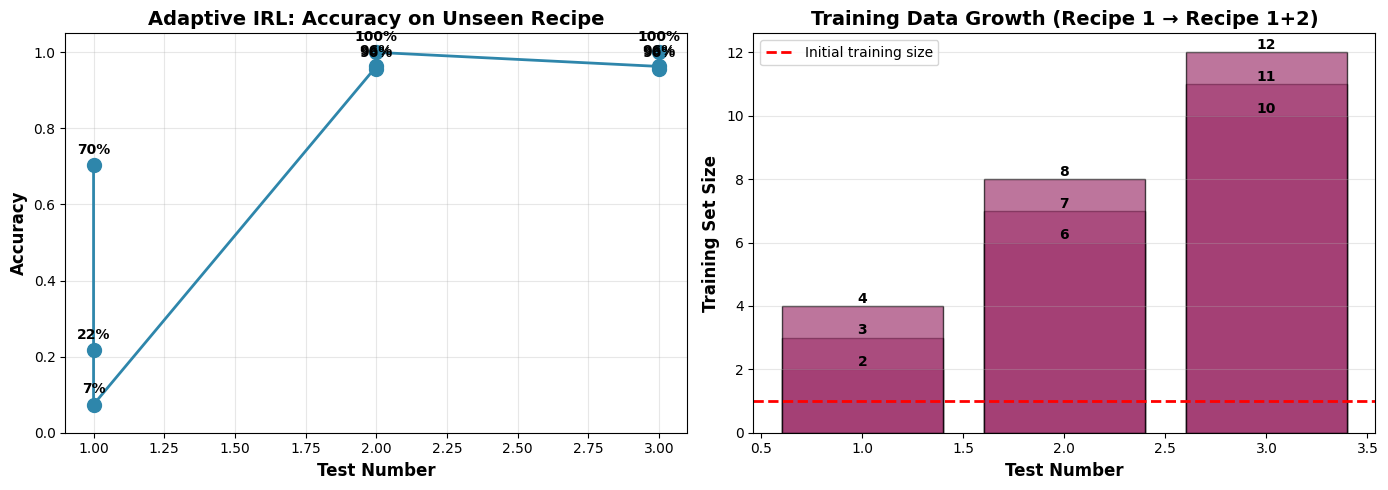


Visualization complete!


In [ ]:
# Optional: Visualize learning progress
import matplotlib.pyplot as plt

if test_history:
    test_nums = [r['test_num'] for r in test_history]
    accuracies = [r['accuracy'] for r in test_history]
    train_sizes = [r['training_size_before'] + r['test_num'] for r in test_history]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Accuracy over tests
    ax1.plot(test_nums, accuracies, marker='o', linewidth=2, markersize=10, color='#2E86AB')
    ax1.set_xlabel('Test Number', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax1.set_title('Adaptive IRL: Accuracy on Unseen Recipe', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1.05)
    for x, y in zip(test_nums, accuracies): ax1.text(x, y + 0.03, f'{y:.0%}', ha='center', fontsize=10, fontweight='bold')
    
    # Plot 2: Training set growth
    ax2.bar(test_nums, train_sizes, color='#A23B72', alpha=0.7, edgecolor='black')
    ax2.axhline(y=len(train_demonstrations), color='red', linestyle='--', label='Initial training size', linewidth=2)
    ax2.set_xlabel('Test Number', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Training Set Size', fontsize=12, fontweight='bold')
    ax2.set_title('Training Data Growth (Recipe 1 → Recipe 1+2)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.legend()
    for x, y in zip(test_nums, train_sizes): ax2.text(x, y + 0.1, f'{y}', ha='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\nVisualization complete!")